# 02 - Data Cleaning & Preprocessing

Notebook này thực hiện làm sạch và preprocessing dữ liệu phim.

## Mục Tiêu
- Xử lý missing values
- Loại bỏ duplicates
- Xử lý outliers
- Feature engineering
- Text vectorization (TF-IDF)

## 1. Import Libraries

In [44]:
import sys
import os

# Add src to path
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_processing.cleaner import MovieDataCleaner
from data_processing.preprocessor import MovieDataPreprocessor

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 2. Load Data

In [45]:
# Load raw data
data_dir = '../data/raw/ml-latest-small'

movies = pd.read_csv(f'{data_dir}/movies.csv')
ratings = pd.read_csv(f'{data_dir}/ratings.csv')
tags = pd.read_csv(f'{data_dir}/tags.csv')
links = pd.read_csv(f'{data_dir}/links.csv')

print(f"Loaded {len(movies)} movies, {len(ratings)} ratings, {len(tags)} tags")
print(f"\nMovies shape: {movies.shape}")
print(f"Ratings shape: {ratings.shape}")

Loaded 9742 movies, 100836 ratings, 3683 tags

Movies shape: (9742, 3)
Ratings shape: (100836, 4)


## 3. Data Quality Assessment

In [46]:
cleaner = MovieDataCleaner(verbose=True)

print("=" * 50)
print("MISSING VALUES CHECK")
print("=" * 50)

print("\nMovies:")
missing_movies = cleaner.check_missing_values(movies)
if len(missing_movies) > 0:
    print(missing_movies)
else:
    print("No missing values found")

print("\nRatings:")
missing_ratings = cleaner.check_missing_values(ratings)
if len(missing_ratings) > 0:
    print(missing_ratings)
else:
    print("No missing values found")

MISSING VALUES CHECK

Movies:
No missing values found

Ratings:
No missing values found


In [47]:
print("=" * 50)
print("DUPLICATES CHECK")
print("=" * 50)

print(f"\nMovies duplicates (by movieId): {movies['movieId'].duplicated().sum()}")
print(f"Movies duplicates (all columns): {movies.duplicated().sum()}")

print(f"\nRatings duplicates (all columns): {ratings.duplicated().sum()}")

DUPLICATES CHECK

Movies duplicates (by movieId): 0
Movies duplicates (all columns): 0

Ratings duplicates (all columns): 0


In [48]:
print("=" * 50)
print("DATA INFO")
print("=" * 50)

print("\nMovies Info:")
movies.info()

print("\nRatings Info:")
ratings.info()

DATA INFO

Movies Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## 4. Clean Movies Data

In [49]:
print("=" * 50)
print("CLEANING MOVIES DATA")
print("=" * 50)

movies_clean = movies.copy()

# 1. Remove duplicates nếu có
if movies_clean.duplicated(subset=['movieId']).sum() > 0:
    movies_clean = cleaner.remove_duplicates(movies_clean, subset=['movieId'])

# 2. Handle missing genres (nếu có)
if movies_clean['genres'].isnull().sum() > 0:
    movies_clean = cleaner.handle_missing_values(
        movies_clean, 
        strategy='constant', 
        columns=['genres'], 
        fill_value='(no genres listed)'
    )

print(f"\nCleaned movies: {len(movies_clean)} rows")
movies_clean.head()

CLEANING MOVIES DATA

Cleaned movies: 9742 rows


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## 5. Feature Engineering - Movies

In [50]:
print("=" * 50)
print("FEATURE ENGINEERING")
print("=" * 50)

preprocessor = MovieDataPreprocessor(verbose=True)

# 1. Extract year from title
movies_clean = preprocessor.extract_year_from_title(movies_clean)

# 2. Clean title (remove year)
movies_clean = preprocessor.clean_title(movies_clean)

# 3. Parse genres
movies_clean = preprocessor.parse_genres(movies_clean)

# 4. Create genre features
movies_clean = preprocessor.create_genre_features(movies_clean)

# 5. Create temporal features
movies_clean = preprocessor.create_temporal_features(movies_clean)

print("\nNew columns added:")
new_cols = [col for col in movies_clean.columns if col not in movies.columns]
print(new_cols)

movies_clean.head()

FEATURE ENGINEERING
Found 13 movies without year information
Extracted year from 'title' to 'year'
Cleaned title from 'title' to 'title_clean'
Parsed genres from 'genres'
Created 10 genre binary features
Created temporal features from 'year'

New columns added:
['year', 'title_clean', 'genres_list', 'genres_count', 'is_action', 'is_comedy', 'is_drama', 'is_thriller', 'is_romance', 'is_horror', 'is_sci-fi', 'is_adventure', 'is_crime', 'is_fantasy', 'movie_age', 'decade', 'era']


,movieId,title,genres,year,title_clean,genres_list,genres_count,is_action,is_comedy,is_drama,is_thriller,is_romance,is_horror,is_sci-fi,is_adventure,is_crime,is_fantasy,movie_age,decade,era
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",5,0,1,0,0,0,0,0,1,0,1,30.0,1990.0,80s-90s
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji,"[Adventure, Children, Fantasy]",3,0,0,0,0,0,0,0,1,0,1,30.0,1990.0,80s-90s
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men,"[Comedy, Romance]",2,0,1,0,0,1,0,0,0,0,0,30.0,1990.0,80s-90s
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,Waiting to Exhale,"[Comedy, Drama, Romance]",3,0,1,1,0,1,0,0,0,0,0,30.0,1990.0,80s-90s
4,5,Father of the Bride Part II (1995),Comedy,1995.0,Father of the Bride Part II,[Comedy],1,0,1,0,0,0,0,0,0,0,0,30.0,1990.0,80s-90s


## 6. Add Rating Features

In [51]:
print("=" * 50)
print("RATING FEATURES")
print("=" * 50)

# Create rating features
movies_enriched = preprocessor.create_rating_features(movies_clean, ratings)

print("\nRating features added:")
rating_cols = ['avg_rating', 'std_rating', 'num_ratings', 'popularity', 'rating_confidence']
print(rating_cols)

print("\nSample with rating features:")
movies_enriched[['title_clean', 'year', 'avg_rating', 'num_ratings', 'popularity']].head(10)

RATING FEATURES
Created rating features for 9742 movies

Rating features added:
['avg_rating', 'std_rating', 'num_ratings', 'popularity', 'rating_confidence']

Sample with rating features:


,title_clean,year,avg_rating,num_ratings,popularity
0,Toy Story,1995.0,3.920930,215.0,5.375278
1,Jumanji,1995.0,3.431818,110.0,4.709530
2,Grumpier Old Men,1995.0,3.259615,52.0,3.970292
3,Waiting to Exhale,1995.0,2.357143,7.0,2.079442
4,Father of the Bride Part II,1995.0,3.071429,49.0,3.912023
5,Heat,1995.0,3.946078,102.0,4.634729
6,Sabrina,1995.0,3.185185,54.0,4.007333
7,Tom and Huck,1995.0,2.875000,8.0,2.197225
8,Sudden Death,1995.0,3.125000,16.0,2.833213
9,GoldenEye,1995.0,3.496212,132.0,4.890349


## 7. Handle Outliers in Ratings

In [52]:
print("=" * 50)
print("OUTLIER DETECTION")
print("=" * 50)

# Check for outliers in num_ratings
outliers = cleaner.detect_outliers_iqr(movies_enriched, 'num_ratings')

print(f"\nMovies with outlier rating counts:")
print(movies_enriched[outliers][['title_clean', 'year', 'num_ratings', 'avg_rating']].sort_values('num_ratings', ascending=False).head(10))

OUTLIER DETECTION
Column 'num_ratings': Found 1179 outliers
  Range: [-11.00, 21.00]

Movies with outlier rating counts:
                             title_clean    year  num_ratings  avg_rating
314                         Forrest Gump  1994.0        329.0    4.164134
277            Shawshank Redemption, The  1994.0        317.0    4.429022
257                         Pulp Fiction  1994.0        307.0    4.197068
510            Silence of the Lambs, The  1991.0        279.0    4.161290
1939                         Matrix, The  1999.0        278.0    4.192446
224   Star Wars: Episode IV - A New Hope  1977.0        251.0    4.231076
418                        Jurassic Park  1993.0        238.0    3.750000
97                            Braveheart  1995.0        237.0    4.031646
507           Terminator 2: Judgment Day  1991.0        224.0    3.970982
461                     Schindler's List  1993.0        220.0    4.225000


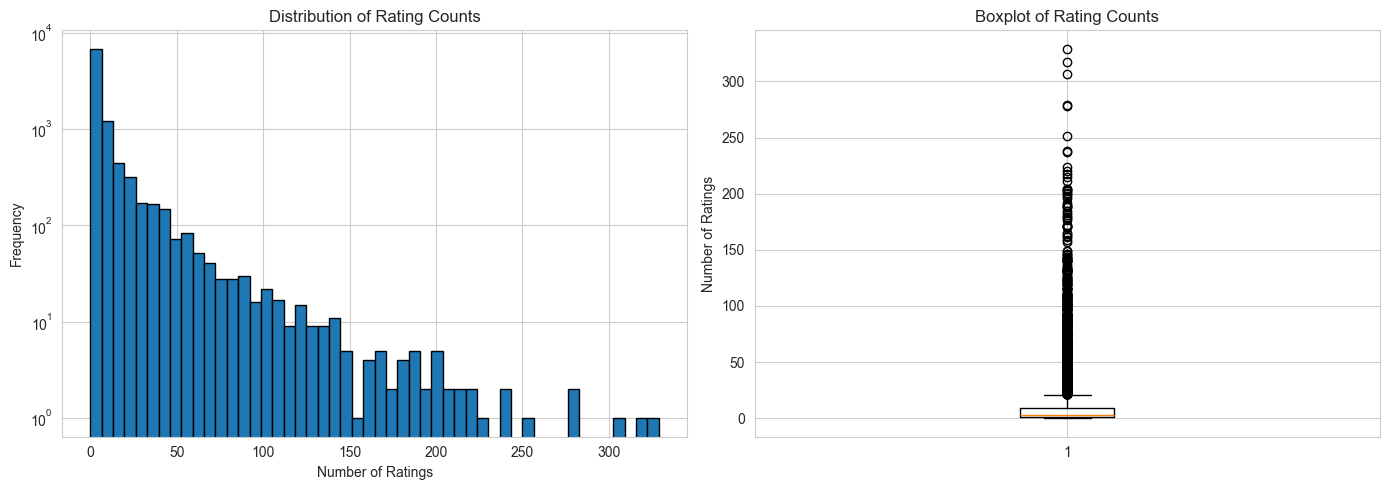


Note: Outliers are expected (popular movies have many more ratings)
We will NOT remove these outliers as they represent real popular movies.


In [53]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of num_ratings
axes[0].hist(movies_enriched['num_ratings'], bins=50, edgecolor='black')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Rating Counts')
axes[0].set_yscale('log')

# Boxplot
axes[1].boxplot(movies_enriched['num_ratings'])
axes[1].set_ylabel('Number of Ratings')
axes[1].set_title('Boxplot of Rating Counts')

plt.tight_layout()
plt.show()

print("\nNote: Outliers are expected (popular movies have many more ratings)")
print("We will NOT remove these outliers as they represent real popular movies.")

## 8. Text Vectorization (TF-IDF)

In [54]:
print("=" * 50)
print("TEXT VECTORIZATION")
print("=" * 50)

# Create combined features (title + genres)
movies_enriched = preprocessor.create_combined_text_features(
    movies_enriched, 
    columns=['title_clean', 'genres']
)

print("\nSample combined features:")
print(movies_enriched[['title_clean', 'genres', 'combined_features']].head())

TEXT VECTORIZATION
Combined text from columns: ['title_clean', 'genres']

Sample combined features:
                   title_clean                                       genres  \
0                    Toy Story  Adventure|Animation|Children|Comedy|Fantasy   
1                      Jumanji                   Adventure|Children|Fantasy   
2             Grumpier Old Men                               Comedy|Romance   
3            Waiting to Exhale                         Comedy|Drama|Romance   
4  Father of the Bride Part II                                       Comedy   

                                   combined_features  
0  Toy Story Adventure|Animation|Children|Comedy|...  
1                 Jumanji Adventure|Children|Fantasy  
2                    Grumpier Old Men Comedy|Romance  
3             Waiting to Exhale Comedy|Drama|Romance  
4                 Father of the Bride Part II Comedy  


In [55]:
# TF-IDF vectorization
tfidf_matrix, tfidf_vectorizer = preprocessor.vectorize_text_tfidf(
    movies_enriched['combined_features'],
    max_features=200,
    ngram_range=(1, 2)
)

print(f"\nTF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

print("\nTop 20 TF-IDF features:")
print(tfidf_vectorizer.get_feature_names_out()[:20])

TF-IDF vectorization: (9742, 200)
  Features: 200, N-grams: (1, 2)

TF-IDF matrix shape: (9742, 200)
Number of features: 200

Top 20 TF-IDF features:
['action' 'action adventure' 'action animation' 'action comedy'
 'action crime' 'action drama' 'action fantasy' 'action horror'
 'action sci' 'action thriller' 'adventure' 'adventure animation'
 'adventure children' 'adventure comedy' 'adventure crime'
 'adventure drama' 'adventure fantasy' 'adventure sci'
 'adventure thriller' 'adventures']


## 9. One-Hot Encode Genres

In [56]:
print("=" * 50)
print("ONE-HOT ENCODING GENRES")
print("=" * 50)

# One-hot encode genres
movies_with_genres, mlb = preprocessor.encode_genres_onehot(movies_enriched)

print(f"\nGenres one-hot encoded: {len(mlb.classes_)}")
print(f"Genre classes: {mlb.classes_}")

print("\nSample with genre encoding:")
genre_cols = [col for col in movies_with_genres.columns if col.startswith('genre_')]
movies_with_genres[['title_clean'] + genre_cols[:5]].head()

ONE-HOT ENCODING GENRES
One-hot encoded 20 genres

Genres one-hot encoded: 20
Genre classes: ['(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'
 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']

Sample with genre encoding:


,title_clean,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children
0,Toy Story,0,0,1,1,1
1,Jumanji,0,0,1,0,1
2,Grumpier Old Men,0,0,0,0,0
3,Waiting to Exhale,0,0,0,0,0
4,Father of the Bride Part II,0,0,0,0,0


## 10. Data Summary

In [57]:
print("=" * 50)
print("FINAL DATASET SUMMARY")
print("=" * 50)

print(f"\nTotal movies: {len(movies_enriched)}")
print(f"Total columns: {len(movies_enriched.columns)}")

print("\nColumn groups:")
print(f"  Original: movieId, title, genres")
print(f"  Extracted: year, title_clean")
print(f"  Genre features: {len([c for c in movies_enriched.columns if c.startswith('is_')])}")
print(f"  Rating features: avg_rating, std_rating, num_ratings, popularity, rating_confidence")
print(f"  Temporal features: movie_age, decade, era")

print("\nMissing values after cleaning:")
missing_final = cleaner.check_missing_values(movies_enriched)
if len(missing_final) > 0:
    print(missing_final)
else:
    print("No missing values!")

print("\nData quality:")
print(f"  Duplicates: {movies_enriched.duplicated(subset=['movieId']).sum()}")
print(f"  Movies with ratings: {(movies_enriched['num_ratings'] > 0).sum()}")
print(f"  Movies with year: {movies_enriched['year'].notna().sum()}")

FINAL DATASET SUMMARY

Total movies: 9742
Total columns: 28

Column groups:
  Original: movieId, title, genres
  Extracted: year, title_clean
  Genre features: 10
  Rating features: avg_rating, std_rating, num_ratings, popularity, rating_confidence
  Temporal features: movie_age, decade, era

Missing values after cleaning:
           Missing Count  Percentage
year                  13    0.133443
movie_age             13    0.133443
decade                13    0.133443

Data quality:
  Duplicates: 0
  Movies with ratings: 9724
  Movies with year: 9729


## 11. Save Processed Data

In [58]:
# Create processed directory
processed_dir = '../data/processed'
os.makedirs(processed_dir, exist_ok=True)

# Save movies enriched
movies_file = os.path.join(processed_dir, 'movies_enriched.csv')
movies_enriched.to_csv(movies_file, index=False)
print(f"Saved: {movies_file}")

# Save movies with one-hot genres (for some models)
movies_genres_file = os.path.join(processed_dir, 'movies_with_genres.csv')
movies_with_genres.to_csv(movies_genres_file, index=False)
print(f"Saved: {movies_genres_file}")

# Save ratings (copy to processed)
ratings_file = os.path.join(processed_dir, 'ratings.csv')
ratings.to_csv(ratings_file, index=False)
print(f"Saved: {ratings_file}")

# Save TF-IDF matrix
import pickle
tfidf_file = os.path.join(processed_dir, 'tfidf_matrix.pkl')
with open(tfidf_file, 'wb') as f:
    pickle.dump({
        'matrix': tfidf_matrix,
        'vectorizer': tfidf_vectorizer
    }, f)
print(f"Saved: {tfidf_file}")

print("\n" + "=" * 50)
print("DATA CLEANING & PREPROCESSING COMPLETED!")
print("=" * 50)

Saved: ../data/processed\movies_enriched.csv
Saved: ../data/processed\movies_with_genres.csv
Saved: ../data/processed\ratings.csv
Saved: ../data/processed\tfidf_matrix.pkl

DATA CLEANING & PREPROCESSING COMPLETED!


## Summary

### Completed Tasks:
1. **Missing Values**: Checked and handled (none found in MovieLens)
2. **Duplicates**: Checked and removed if any
3. **Outliers**: Detected in rating counts (kept as they represent popular movies)
4. **Feature Engineering**:
   - Extracted year from title
   - Parsed genres
   - Created genre features (binary)
   - Created rating features (avg, std, count, popularity)
   - Created temporal features (age, decade, era)
5. **Text Vectorization**:
   - TF-IDF on combined features (title + genres)
   - One-hot encoding for genres

### Files Created:
- `data/processed/movies_enriched.csv` - Main dataset with all features
- `data/processed/movies_with_genres.csv` - Dataset with one-hot encoded genres
- `data/processed/ratings.csv` - Ratings data
- `data/processed/tfidf_matrix.pkl` - TF-IDF matrix and vectorizer

### Next Steps:
- Phase 3: EDA & Visualization
- Phase 4: Model Building